# 在CDNet上进行热力图可视化
CDNet来自论文：Learn-to-Decompose: Cascaded Decomposition Network for Cross-Domain Few-Shot Facial Expression Recognition
本代码中采用经过batch train预训练的模型，不同于resnet或者mobilenet，cdnet使用resnet作为backbone并连接若干L2D模块来分解特征最后使用一个全连接层来进行分类，这样的结构不能使用CAM进行热力图的计算。

### 1.导入环境

In [2]:
from util_files.resnet import ResNet, BasicBlock
from util_files.cdnet import CDNet
import numpy as np
import torch
import torchvision.transforms as Transforms
from util_files.utils3 import ImageJitter
from torchvision.transforms import Compose
from PIL import Image
import matplotlib.pyplot as plt
from util_files.grad_cam import GradCAM,show_cam_on_image, center_crop_img

### 2.定义我们需要可视化的模型
定义这个模型需要传入一些参数，所以我们可以自定义一个ARGS类来代替这些参数。模型的结构如下：
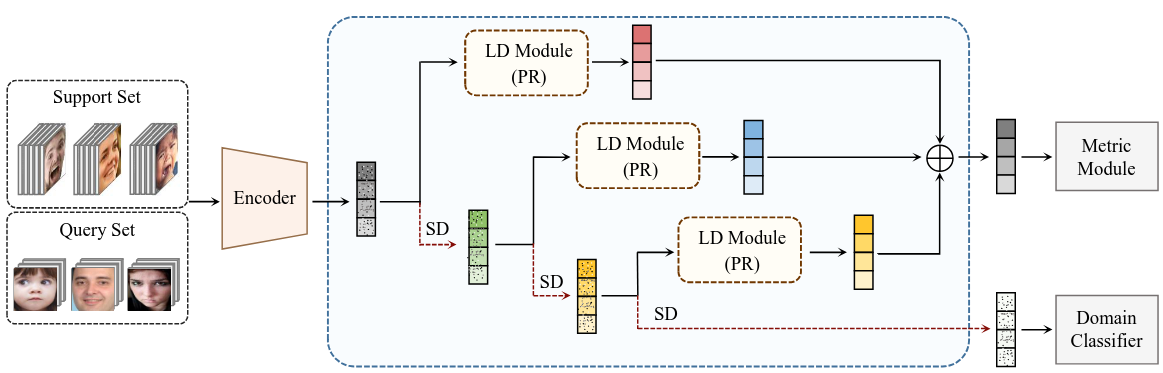\
创建好模型后加载预训练好的权重文件。

In [3]:
# 定义一些参数
class ARGS():
    def __init__(self):
        self.seed = 10
        self.method = "softMax"
        self.lr = 0.001
        self.backbone = "ResNet18"
        self.n_epoch = 100
        self.n_support = 5
        self.n_query = 16
        self.out_dim = 512
        self.img_size = 224
        self.over_fineTune = False
        self.color = 3
        self.n_domains = 5
        self.ft_n_epoch = 50
        self.n_way = 5
        self.n_shot = 5
args = ARGS()

# 定义一个backbone
net = ResNet(BasicBlock, [2, 2, 2, 2], 8)

# 定义模型
model = CDNet(args, net, 8)

# 加载预训练模型
checkpoint = torch.load("best_model.tar")
model.net.load_state_dict(checkpoint["state"])
model.decomposition.load_state_dict(checkpoint['decomposition'])
model.weight_net.load_state_dict(checkpoint['weight_net'])
model.base_clf.load_state_dict(checkpoint['base_clf'])

<All keys matched successfully>

### 3.加载测试图片
加载测试图片后要做和测试模型时同样的预处理方式。\
由于BN层的存在，批量为1的数据输入模型会报错，所以把输入图像复制一份形成batch_size=2的小批量

In [4]:
# 读取测试图片
# 对输入图像做transform，步骤和正常的模型测试一模一样
norm_mean, norm_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
jitter_param = dict(Brightness=0.4, Contrast=0.4, Color=0.4, )
data_transform = transforms = Compose([Transforms.RandomResizedCrop(args.img_size),
                              ImageJitter(jitter_param),
                              Transforms.RandomHorizontalFlip(),
                              Transforms.ToTensor(),
                              Transforms.Normalize(norm_mean, norm_std)])

# 测试图片
img_path = "face.jpg"
img = Image.open(img_path).convert("RGB")
input_tensor = data_transform(img)
# 复制一份图片形成batch_size=2的小批量
stacked_tensor = torch.stack([input_tensor, input_tensor], dim=0)

### 4.定义cam
定义cam需要指定两个东西：\
1.模型的其中一个卷积层layer\
2.想要可视化的类别i\
这样最后生成的热力图就是**对于i这个类别在layer这个层模型的关注位置**。

In [5]:
target_layers = [model.net.layer4]
# 定义Cam
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False)

# 我们需要制定一个类别来显示热力图，281的类别为cat，254的类别为dog
target_category = 2

### 5.将生成的热力图可视化

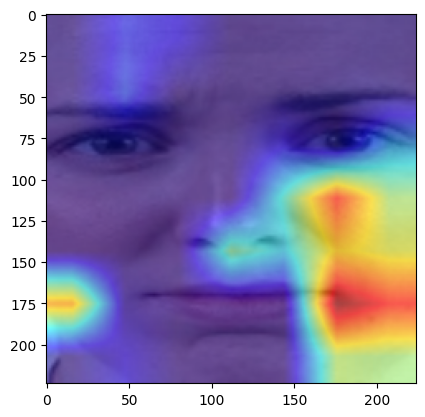

In [14]:
# 后边就是固定搭配，可视化
stacked_tensor.cuda()
model.cuda()
grayscale_cam = cam(input_tensor=stacked_tensor, target_category=target_category)
grayscale_cam = grayscale_cam[0, :]

# 将原图resize到224，然后转化成numpy矩阵
img_v = Transforms.Resize(224)(img)
img_v = np.array(img_v)
visualization = show_cam_on_image(img_v.astype(dtype=np.float32) / 255.,
                                      grayscale_cam,
                                      use_rgb=True)
plt.imshow(visualization)
plt.show()